In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import tensorflow as tf
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(df.iloc[:, 1:-1]))
Y = LabelEncoder().fit_transform(df.iloc[:, -1])
onehot_y = np.zeros((X.shape[0], np.unique(Y).shape[0]))
for k in range(X.shape[0]):
    onehot_y[k, Y[k]] = 1.0

In [4]:
class Normal_model:
    def __init__(self, learning_rate, layer_size):
        self.X = tf.placeholder(tf.float32, (None, X.shape[1]))
        self.Y = tf.placeholder(tf.float32, (None, np.unique(Y).shape[0]))
        w1 = tf.Variable(tf.random_normal([X.shape[1], layer_size]))
        b1 = tf.Variable(tf.random_normal([layer_size]))
        w2 = tf.Variable(tf.random_normal([layer_size, layer_size]))
        b2 = tf.Variable(tf.random_normal([layer_size]))
        w3 = tf.Variable(tf.random_normal([layer_size, np.unique(Y).shape[0]]))
        b3 = tf.Variable(tf.random_normal([np.unique(Y).shape[0]]))
        self.logits = tf.nn.sigmoid(tf.matmul(self.X, w1) + b1)
        self.logits = tf.nn.sigmoid(tf.matmul(self.logits, w2) + b2)
        self.logits = tf.matmul(self.logits, w3) + b3
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cost)
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
class Dropout_model:
    def __init__(self, learning_rate, layer_size):
        self.X = tf.placeholder(tf.float32, (None, X.shape[1]))
        self.Y = tf.placeholder(tf.float32, (None, np.unique(Y).shape[0]))
        w1 = tf.Variable(tf.random_normal([X.shape[1], layer_size]))
        b1 = tf.Variable(tf.random_normal([layer_size]))
        w2 = tf.Variable(tf.random_normal([layer_size, layer_size]))
        b2 = tf.Variable(tf.random_normal([layer_size]))
        w3 = tf.Variable(tf.random_normal([layer_size, np.unique(Y).shape[0]]))
        b3 = tf.Variable(tf.random_normal([np.unique(Y).shape[0]]))
        self.logits = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(self.X, w1) + b1), 0.8)
        self.logits = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(self.logits, w2) + b2), 0.8)
        self.logits = tf.matmul(self.logits, w3) + b3
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cost)
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [5]:
tf.reset_default_graph()
first_graph = tf.Graph()
with first_graph.as_default():
    gd = Normal_model(0.1, 128)
    first_sess = tf.InteractiveSession()
    first_sess.run(tf.global_variables_initializer())
    
second_graph = tf.Graph()
with second_graph.as_default():
    dropout = Dropout_model(0.1, 128)
    second_sess = tf.InteractiveSession()
    second_sess.run(tf.global_variables_initializer())

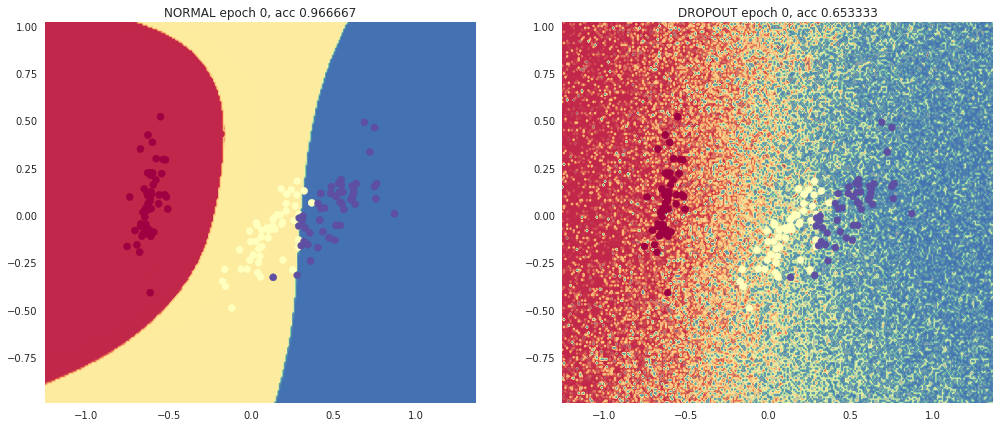

In [6]:
fig = plt.figure(figsize=(17,7))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
concated = np.c_[xx.ravel(), yy.ravel()]
plt.subplot(1, 2, 1)
Z = first_sess.run(gd.logits, feed_dict={gd.X:concated})
acc = first_sess.run(gd.accuracy, feed_dict={gd.X:X, gd.Y:onehot_y})
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha =0.5)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title('NORMAL epoch %d, acc %f'%(0, acc))
plt.subplot(1, 2, 2)
Z = second_sess.run(dropout.logits, feed_dict={dropout.X:concated})
acc = second_sess.run(dropout.accuracy, feed_dict={dropout.X:X, dropout.Y:onehot_y})
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha =0.5)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title('DROPOUT epoch %d, acc %f'%(0, acc))

def training(epoch):
    plt.subplot(1, 2, 1)
    first_sess.run(gd.optimizer, feed_dict={gd.X:X, gd.Y:onehot_y})
    Z = first_sess.run(gd.logits, feed_dict={gd.X:concated})
    acc = first_sess.run(gd.accuracy, feed_dict={gd.X:X, gd.Y:onehot_y})
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha =0.5)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
    plt.title('NORMAL epoch %d, acc %f'%(epoch, acc))
    plt.subplot(1, 2, 2)
    second_sess.run(dropout.optimizer, feed_dict={dropout.X:X, dropout.Y:onehot_y})
    Z = second_sess.run(dropout.logits, feed_dict={dropout.X:concated})
    acc = second_sess.run(dropout.accuracy, feed_dict={dropout.X:X, dropout.Y:onehot_y})
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha =0.5)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
    cont = plt.title('DROPOUT epoch %d, acc %f'%(epoch, acc))
    return cont
    
anim = animation.FuncAnimation(fig, training, frames=100, interval=200)
anim.save('animation-dropoutcomparison-iris.gif', writer='imagemagick', fps=5)